# Understanding Llama2 with Captum LLM Attribution

In this tutorial, we will demonstrate the LLM attribution functionality introduced in Captum v0.7, which makes it a breeze to applying the attribution algorithms to interpret the large langague models (LLM) in text generation. Please note that executing some of the cells in this notebook require Captum v0.8 or a manual install. The new functionalities include a series utilities that help you with many common tedious scaffolding required by LLMs like defining intepretable features in text input and handling the sequential predictions. You can also check our paper for more details https://arxiv.org/abs/2312.05491

Next, we will use Llama2 (7b-chat) as an example and use both perturbation-based and grandient-based algrithms respectively to see how the input prompts lead to the generated content. First, let's import the needed dependencies. Specifically, from Captum, besides the algorithms `FeatureAblation` and `LayerIntegratedGradients` themselves, we will also import:
- perturbation-based and gradient-based wrappers for LLM, `LLMAttribution` and `LLMGradientAttribution`
- text-based interpretable input adapters, `TextTokenInput` and `TextTemplateInput`

In [1]:
import warnings

import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

# Ignore warnings due to transformers library
warnings.filterwarnings("ignore", ".*past_key_values.*")
warnings.filterwarnings("ignore", ".*Skipping this token.*")

## Preparation

Let's make a helper function to load models through Huggingface. We will also add an extra step for 4-bits quantization which can effectively reduce the GPU memory consumption. Now, we can use them to load "Llama-2-7b-chat".

In [2]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",  # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [3]:
model_name = "meta-llama/Llama-2-13b-chat-hf" 

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Let's test the model with a simple prompt and take a look at the output.

In [4]:
eval_prompt = "Dave lives in Palm Coast, FL and is a lawyer. His personal interests include"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=15)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)

Dave lives in Palm Coast, FL and is a lawyer. His personal interests include travel, golf, and hiking.

Dave is a


## Perturbation-based Attribution

OK now, the model is working and has completed the given prompt by producing several possible interests. To understand how the model produces them based on the prompt, we will first use the perturbation-based algrotihms from Captum to understand the generation. We can start with the simplest `FeatureAblation`, which ablates each of the features of this string to see how it affects the predicted probability of the target string. The way is the same as before: feed the model into the corresponding constructor to initiate the attribution method. But additionally, to help it work with text-based input and output, we need to wrap it with the new `LLMAttribution` class.

In [5]:
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)

The newly created `llm_attr` is the same as the wrapped attribution method instance which provides an `.attribute()` function taking the model inputs and returns the attribution scores of cared features within the inputs. However, by default, Captum's attribution algorithms assume each input into the model must be PyTorch tensors and perturb them at tensor level. This is likely not what we want for LLM, where we are more interested in the interpretable text input and making text modifications like removing a text segment, than a less meaningful tensor of token indices. To solve this, we introduce a new adapter design called `InterpretableInput` which handles the conversion between more interpretable input type and tensor, and tells Captum how to work with them. `llm_attr` is made to accept certain text-based `InterpretableInput` as the arguements. The concept of "Interpretable Input" mainly comes from the following two papers:
- [“Why Should I Trust You?”: Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938)
- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)

The question now is what are the intepretable features we want to understand in text. One most common and straightforward answer is "tokens". And we provide `TextTokenInput` specifically for such use cases. `TextTokenInput` is an `InterpretableInput` for text whose interpretable features are the tokens with respect to a given tokenizer. So let's create one and calculate its attribution w.r.t the previous generated output as the target:

In [6]:
skip_tokens = [1]  # skip the special token for the start of the text <s>
inp = TextTokenInput(
    eval_prompt, 
    tokenizer,
    skip_tokens=skip_tokens,
)

target = "playing guitar, hiking, and spending time with his family."

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

With just a few lines of codes, we now get the `FeatureAblation` attribution result of our LLM. The return contains the attribution tensors to both the entire generated target seqeuence and each generated token, which tell us how each input token impact the output and each token within it.

In [7]:
print("attr to the output sequence:", attr_res.seq_attr.shape)  # shape(n_input_token)
print("attr to the output tokens:", attr_res.token_attr.shape)  # shape(n_output_token, n_input_token)

attr to the output sequence: torch.Size([18])
attr to the output tokens: torch.Size([15, 18])


It also provides the utilities to visualize the results. Next we will plot the token attribution to view the relations between input and output tokens. As we will see, the result is generally very positive. This is expected, since the target, "playing guitar, hiking, and spending time with his family", is what the model feel confident to generate by itself given the input tokens. So change in the input is more likely divert the model from this target.

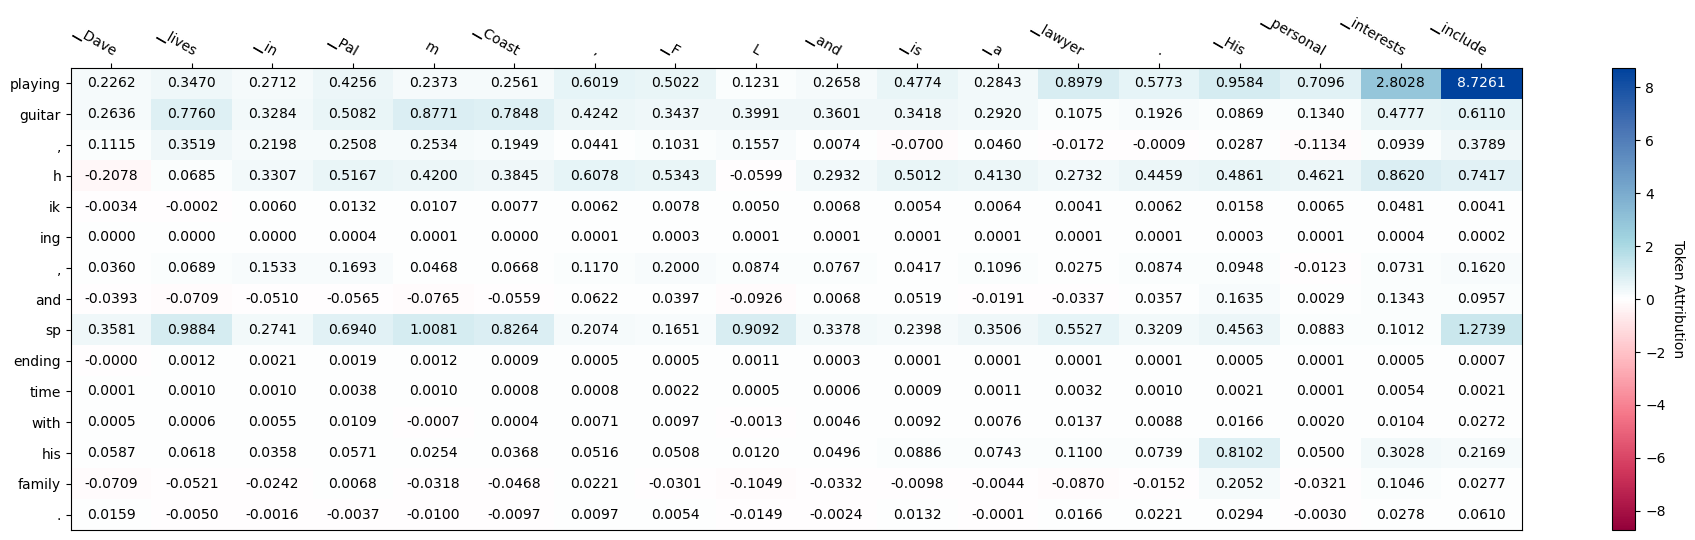

In [8]:
attr_res.plot_token_attr(show=True)

However, it may not always make sense to define individual token as intepretable features and perturb it. Tokenizers used in modern LLMs may break a single word making the tokens not intepretable by themselves. For example, in our case above, the tokenizer can break the word "Palm" into "_Pal" and "m". It doesn't make much sense to study the separate attribution of them. Moreover, even a whole word can be meaningless. For example, "Palm Coast" together result in a city name. Changing just partial of its tokens would likely not give anything belongs to the natural distribution of potential cities in Florida, which may lead to unexpected impacts on the perturbed model output.

Therefore, Captum offers another more customizable interpretable input class, `TextTemplateInput`, whose interpretable features are certain segments (e.g., words, phrases) of the text defined by the users. For instance, our prompt above contains information about name, city, state, occupation, and pronoun. Let's define them as the interpretable features to get their attribution. 

The target to interpret can be any potential generations that we are interested in. Next, we will customize the target to something else.

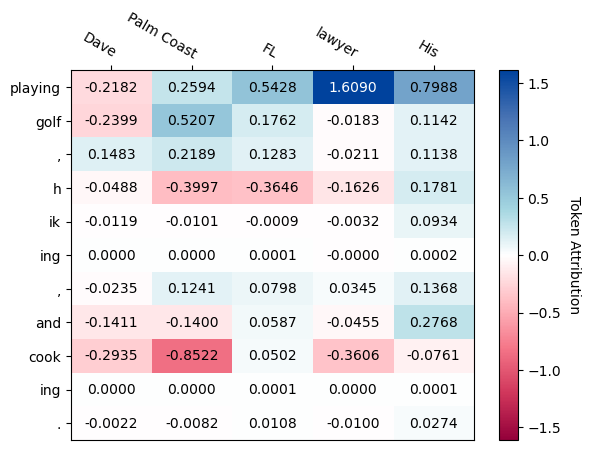

In [9]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} personal interests include", 
    values=["Dave", "Palm Coast", "FL", "lawyer", "His"],
)

target = "playing golf, hiking, and cooking."

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

We know that perturbation-based algrotihms calculate the attribution by switching the features between "presence" and "absence" states. So what should a text feature look like here when it is in "absence" in the above example? Captum allows users to set the baselines, i.e., the reference values, to use when a feature is absent. By default, `TextTemplateInput` uses empty string `''` as the baselines for all, which is equivalent to the removal of the segments. This may not be perfect for the same out-of-distribution reason. For example, when the feature "name" is absent, the prompt loses its subjective and no longer makes much sense. 

To improve it, let's manually set the baselines to something that still fit the context of the original text and keep it within the natural data distribution.

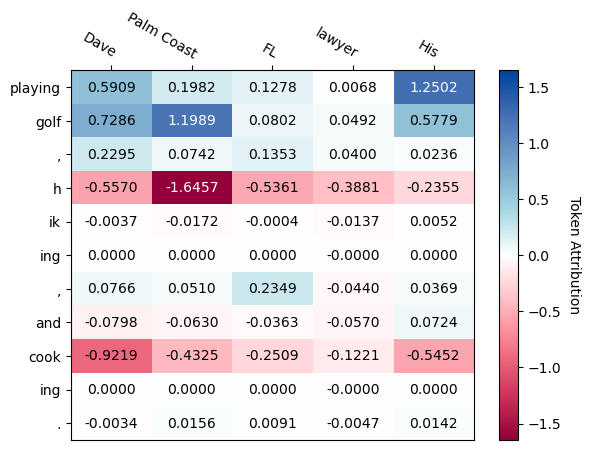

In [10]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} personal interests include", 
    values=["Dave", "Palm Coast", "FL", "lawyer", "His"],
    baselines=["Sarah", "Seattle", "WA", "doctor", "Her"],
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

The result represents how the features impacts the output compared with the single baseline. It can be a useful setup to have some interesting findings. For example, the city name "Palm Coast" is more positive to "playing golf" but negative to "hiking" compared with "Seattle".

But more generally, we would prefer a distribution of baselines so the attribution method will sample from for generosity. Here, we can leverage the `ProductBaselines` to define a Cartesian product of different baselines values of various features. And we can specify `num_trials` in attribute to average over multiple trials

Another issue we notice from the above results is that there are correlated aspects of the prompt which should be ablated together to ensure that the input remain in distribution, e.g. Palm Coast, FL should be ablated with Seattle, WA. We can accomplish this using a mask as defined below, which will group (city, state) and (name, pronoun). `TextTemplateFeature` accepts the argument `mask` allowing us to set the group indices. To make it more explicit, we can also define the template and its values in dictionary format instead of list.

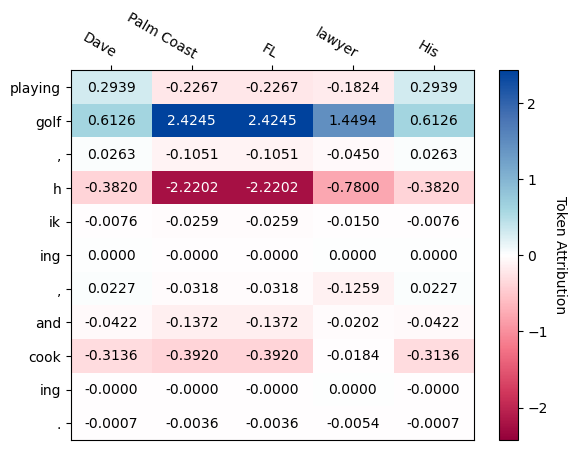

In [11]:
baselines = ProductBaselines(
    {
        ("name", "pronoun"):[("Sarah", "her"), ("John", "His"), ("Martin", "His"), ("Rachel", "Her")],
        ("city", "state"): [("Seattle", "WA"), ("Boston", "MA")],
        "occupation": ["doctor", "engineer", "teacher", "technician", "plumber"], 
    }
)

inp = TextTemplateInput(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    values={"name": "Dave", "city": "Palm Coast", "state": "FL", "occupation": "lawyer", "pronoun": "His"}, 
    baselines=baselines,
    mask={"name": 0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

One potential issue with the current approach is using Feature Ablation. If the model learns complex interations between the prompt features, the true importance may not be reflected in the attribution scores. Consider a case where the model predicts a high probability of playing golf if a person is either a lawyer or lives in Palm Coast. By ablating a feature one at a time, the probability may appear to be unchanged when ablating each feature independently, but may drop substantially when perturbing both together.

To address this, we can apply alternate perturbation-based attribution methods available in Captum such as ShapleyValue(Sampling), KernelShap and Lime, which ablate different subgroups of features and may result in more accurate scores.

We will use `ShapleyValue` below because we essentially only have three features now after grouping. The computation is tractable.

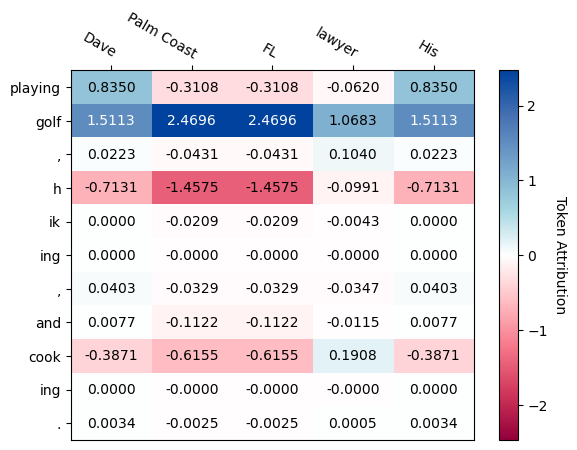

In [12]:
sv = ShapleyValues(model) 

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

Let's now consider a more complex example, where we use the LLM as a few-shot learner to classify sample movie reviews as positive or negative. We want to measure the relative impact of the few shot examples. Since the prompt changes slightly in the case that no examples are needed, we define a prompt function rather than a format string in this case.

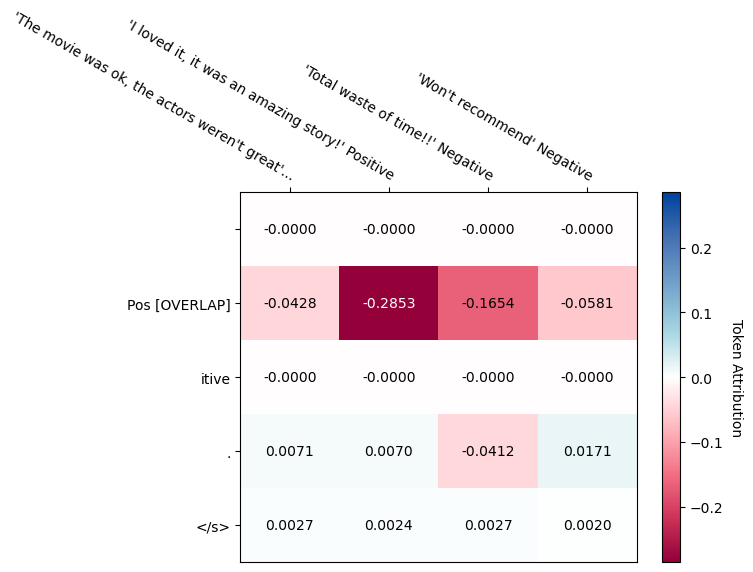

In [13]:
def prompt_fn(*examples):
    main_prompt = "Decide if the following movie review enclosed in quotes is Positive or Negative:\n'I really liked the Avengers, it had a captivating plot!'\nReply only Positive or Negative."
    subset = [elem for elem in examples if elem]
    if not subset:
        prompt = main_prompt
    else:
        prefix = "Here are some examples of movie reviews and classification of whether they were Positive or Negative:\n"
        prompt = prefix + " \n".join(subset) + "\n " + main_prompt
    return "[INST] " + prompt + "[/INST]"

input_examples = [
    "'The movie was ok, the actors weren't great' Negative", 
    "'I loved it, it was an amazing story!' Positive",
    "'Total waste of time!!' Negative", 
    "'Won't recommend' Negative",
]
inp = TextTemplateInput(
    prompt_fn, 
    values=input_examples,
)

attr_res = sv_llm_attr.attribute(inp, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

Interestingly, we can see all these few-shot examples we choose actually make the model less likely to correctly label the given review as "Positive".

# Gradient-based Attribution
As an alternative to perturbation-based attribution, we can use gradient-based methods to attribute each feature's contribution to a target sequence being generated. For LLMs, the only supported method at present is `LayerIntegratedGradients`. Layer Integrated Gradients is a variant of Integrated Gradients that assigns an importance score to layer inputs or outputs. Integrated Gradients works by assigning an importance score to each input feature by approximating the integral of gradients of a function's output with respect to the inputs along the path from given references to inputs. To instantiate, we can simply wrap our gradient-based attribution method with `LLMGradientAttribution`. Here, we measure the importance of each input token to the embedding layer `model.embed_tokens` of the LLM.

In [14]:
lig = LayerIntegratedGradients(model, model.model.embed_tokens)

llm_attr = LLMGradientAttribution(lig, tokenizer)

Now that we have our LLM attribution object, we can similarly call `.attribute()` to obtain our gradient-based attributions. Right now, `LLMGradientAttribution` can only handle `TextTokenInput` inputs. We can visualize the attribution with respect to both the full output sequence and individual output tokens using the methods `.plot_seq_attr()` and `.plot_token_attr()`, respectively.

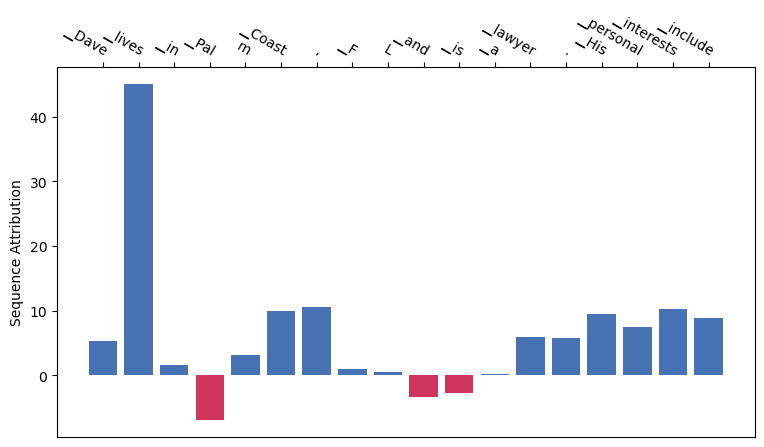

In [15]:
inp = TextTokenInput(
    eval_prompt,
    tokenizer,
    skip_tokens=skip_tokens,
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_seq_attr(show=True)

Layer Integrated Gradients estimates that the most important input token in the prediction of the subsequent tokens in the sentence is the word, "lives." We can visualize further token-level attribution at the embedding layer as well.

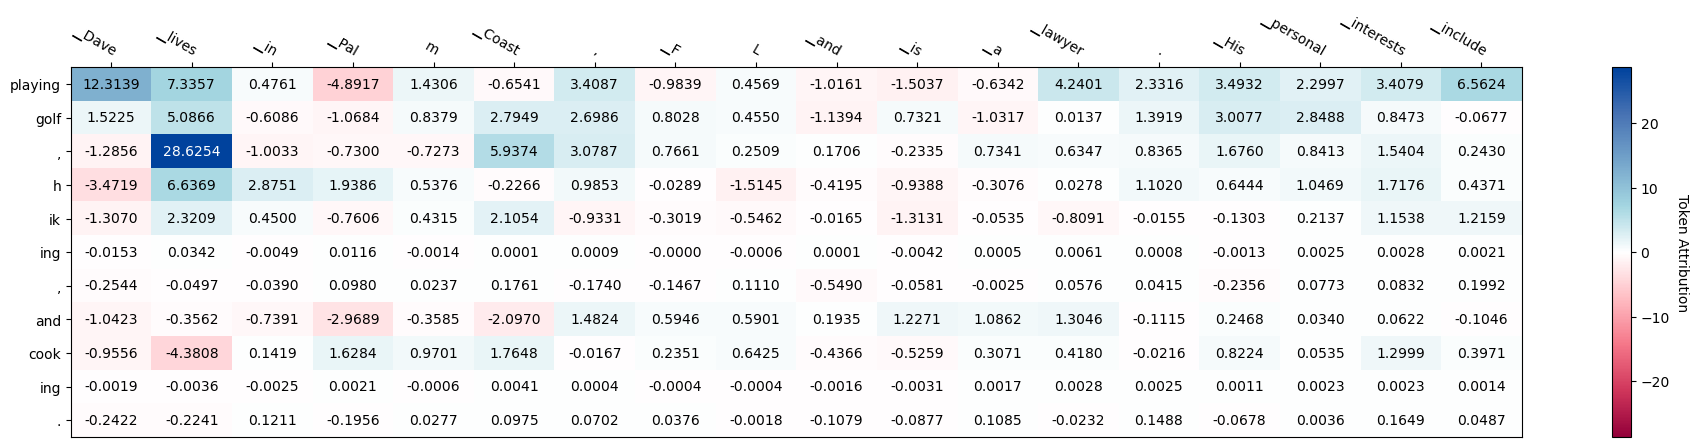

In [16]:
attr_res.plot_token_attr(show=True)

Keep in mind that the token- and sequence-wise attribution will change layer to layer. We encourage you to explore how this attribution changes with alternative layers in the LLM.